In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import urllib
#------------------
from dataset import RandomTestDataset
from models import MLP
from resnet_family import resnet20_cifar
from utils_cm import compute_cm

## Evaluate the confidence of the model on unseen categories

In [ ]:
# image = image.resize((32, 32))
transform = transforms.Compose([transforms.Resize((32, 32)), 
                                       transforms.ToTensor(), 
                                       transforms.Normalize(mean=[0.491, 0.482, 0.446], std=[0.247, 0.243, 0.261])])
seen_classes = RandomTestDataset('./images/seen_cifar10', transform=transform)
unseen_classes = RandomTestDataset('./images/unseen_cifar10', transform=transform)
seen_dataloader = DataLoader(seen_classes, batch_size=1, shuffle=False)
unseen_dataloader = DataLoader(unseen_classes, batch_size=1, shuffle=False)

In [ ]:
labels_cifar10 = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']

model = resnet20_cifar()
model.eval()

seen = []
unseen = []

for i_iter, batch in enumerate(seen_dataloader):
    image, file_name = batch
    output = model(image)
    score, label = F.softmax(output, dim=1).max(1)
    full_file_name = os.path.join('./images/seen_cifar10', file_name[0])
    seen.append({'fname': full_file_name, 'prediction': labels_cifar10[label], 'score': np.round(score.item(), 3)})
    
for i_iter, batch in enumerate(unseen_dataloader):
    image, file_name = batch
    output = model(image)
    score, label = F.softmax(output, dim=1).max(1)
    full_file_name = os.path.join('./images/unseen_cifar10', file_name[0])
    unseen.append({'fname': full_file_name, 'prediction': labels_cifar10[label], 'score': np.round(score.item(), 3)})

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(16, 8))
for i in range(len(seen)):
    image = Image.open(seen[i]['fname'])
    ax[0, i].imshow(image)
    ax[0, i].set_title(f"{seen[i]['prediction']}, {seen[i]['score']}")
    image = Image.open(unseen[i]['fname'])
    ax[1, i].imshow(image)
    ax[1, i].set_title(f"{unseen[i]['prediction']}, {unseen[i]['score']}")

# Gaussian Processes, Bayesian Optimisation, and Bayesian NNs using DropOut

### Good reads:
[A Tutorial on Bayesian Optimization of Expensive Cost Functions](docs/BayesianOptimisation.pdf)

[What My Deep Model Doesn't Know](http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html)

[Leveraging uncertainty information from deep neural networks for disease detection](docs/BayesianDNN_nature_eye_disease.pdf)

[Bayesian CNNs](https://arxiv.org/pdf/1506.02158.pdf)

## Experiments on MNIST

We build a shallow network and test it in MNST data, and run some experiments similar to what shown in [here](http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html) and [here](https://xuwd11.github.io/Dropout_Tutorial_in_PyTorch/).

### Preparing the dataset

In [ ]:
batch_size = 64
mnist_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# Train Set:
mnist_train_dataset = torchvision.datasets.MNIST('./data/', train=True, download=True, transform=mnist_transform)
mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True)
# Test Set:
mnist_test_dataset = torchvision.datasets.MNIST('./data/', train=False, download=True, transform=mnist_transform)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
sample_data = next(enumerate(mnist_train_loader))
sample_data = sample_data[1][0].view(batch_size, 784)[0, :].view(28, 28).data.numpy()
plt.imshow(sample_data)

### Build the model and configure the training

In [ ]:
mlp = MLP(input_size=28*28, nclasses=10, hidden_layers=[64, 64], dropout=0.5)
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
mlp.net

In [ ]:
n_epochs = 10
loss_value = 0
reset_loss_every = 300
device = "cpu"

In [ ]:
for epoch in range(n_epochs):
    for it, train_batch in enumerate(mnist_train_loader):
        mlp.train()
        
        images, train_labels_batch = train_batch
        train_data_batch = images.view(train_labels_batch.shape[0], 784)
        output = mlp(train_data_batch)
        optimizer.zero_grad()
        loss = F.cross_entropy(output, train_labels_batch.to(device), reduction="mean")
        
        loss.backward()
        loss_value += loss.item()
        optimizer.step()
        
        if (it % reset_loss_every) == 0 and it > 0:
            print(f"epoch: {epoch}, iteration: {it}, loss_value: {loss_value/reset_loss_every}")
            loss_value = 0

### Evaluating on the test set

In [ ]:
mlp.eval()
gt_test, preds_test = [], []
for it_test, test_batch in enumerate(mnist_test_loader):
    images, test_labels_batch = test_batch
    test_data_batch = images.view(test_labels_batch.shape[0], 784)
    output_test = mlp(test_data_batch.to(device).float())
    preds_test.append(F.softmax(output_test, dim=1).data.numpy())
    gt_test.append(test_labels_batch.numpy())
preds_test = np.vstack(preds_test)
preds_test_labels = preds_test.argmax(-1)
preds_test_score = preds_test.max(-1)
gt_test = np.hstack(gt_test)
recall, precision = compute_cm(gt_test, preds_test_labels, classes=range(10))
print(f'average recall: {recall.mean()},  average precision: {precision.mean()}')
preds_test.shape

### Identify the incorrectly classified images and check their softmax scores (And potentially their entropy)

In [ ]:
bad_preds = np.where(gt_test != preds_test_labels)

### Re-evaluate those images, but with active DropOut 

### Check the distribution of their ensemble scores before and after Softmax

# Uncertainty of the model is not exactly the softmax probability

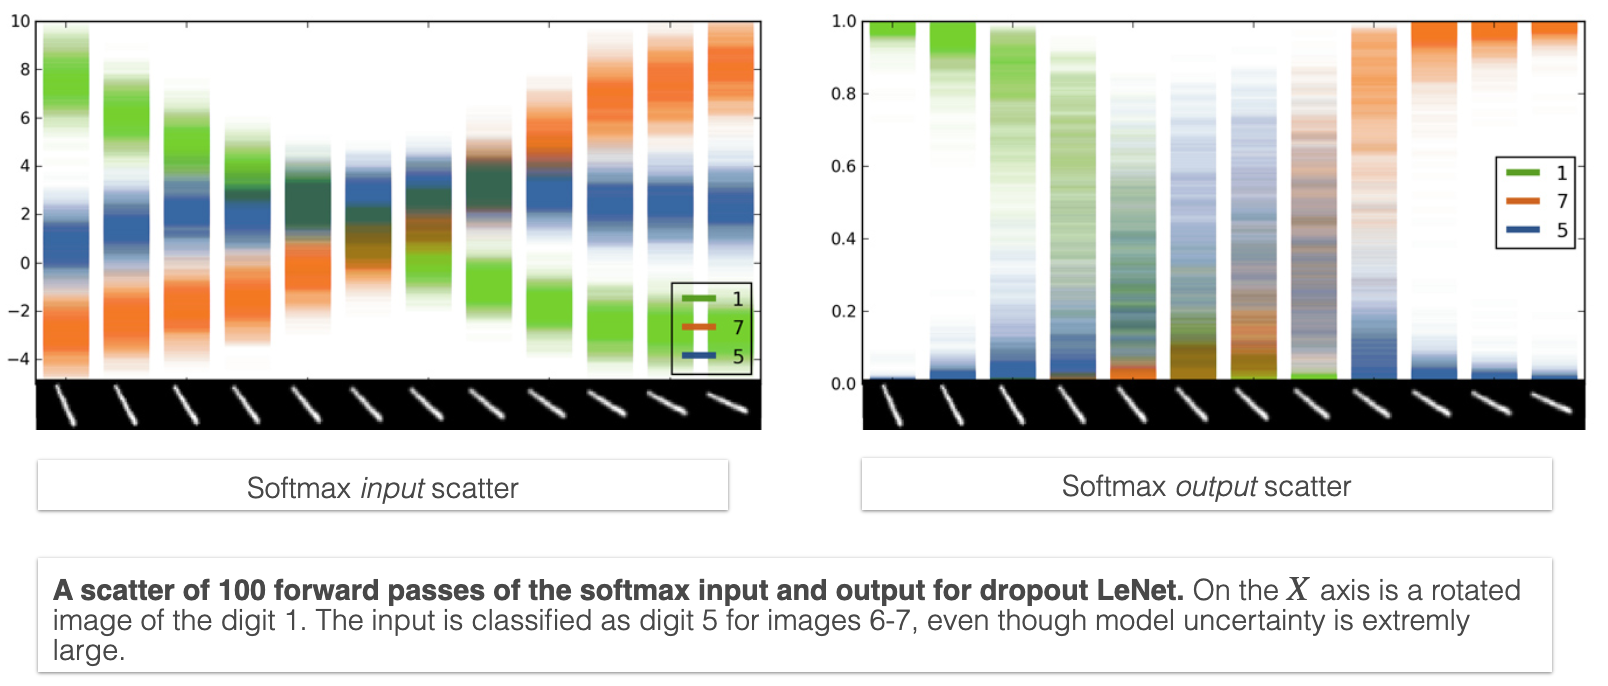

Without DropOut, the network always gives you a single prediction, which has been computed using the point estimates of the network weights. However, using DropOut, you bring Bayesian Optimisation into the model by treating the network weights as PDF functions rather than point estimates. Therefore the model objective function can be treated as a Gaussian Process over all network weights. 

In the figure above [YarinGal.etal.2016](http://proceedings.mlr.press/v48/gal16.pdf), we see the distribution of 100 evaluations of the dropout network for each rotated image. Given the stochasticity of the model, we get 100 different scores (left figure) and 100 different probabilities (right figure) for Each class. 
We can see for example, the 100 different predictions for class 1 in the first image of the right figure have the highest predictive mean and a very low variance, and the 200 predictions for the classes 5 and 7 all have a predictive mean of almost zero, again with a very low uncertainty.

However, for the images in the middle of the right figure, even though class 5 has been selected with highest predictive mean, there is a lot of uncertainty for it.

NOTE: One thing that I am still confused about is why we have a low uncertainty and large predictive mean for the right-most image (classified as class 7), even though the image is not really a class 7...